<a href="https://colab.research.google.com/github/markusstrasser/deforum/blob/main/Deforum_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deforum Stable Diffusion v0.5**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

By using this Notebook, you agree to the following Terms of Use, and license:

**Stablity.AI Model Terms of Use**

This model is open access and available to all, with a CreativeML OpenRAIL-M license further specifying rights and usage.

The CreativeML OpenRAIL License specifies:

You can't use the model to deliberately produce nor share illegal or harmful outputs or content
CompVis claims no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in the license
You may re-distribute the weights and use the model commercially and/or as a service. If you do, please be aware you have to include the same use restrictions as the ones in the license and share a copy of the CreativeML OpenRAIL-M to all your users (please read the license entirely and carefully)


Please read the full license here: https://huggingface.co/spaces/CompVis/stable-diffusion-license

# Setup

In [1]:
!rm -rf stable-diffusion/
!rm -rf src
!rm -rf pytorch3d-lite/
!rm -rf MiDaS
!rm -rf k-diffusion
!rm -rf AdaBins

#@markdown **NVIDIA GPU**
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)



setup_environment = True #@param {type:"boolean"}
print_subprocess = False #@param {type:"boolean"}

if setup_environment:
    import subprocess, time
    print("Setting up environment...")
    start_time = time.time()
    all_process = [
        ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
        ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
        ['git', 'clone',  'https://github.com/deforum/stable-diffusion'],
        ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
        ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
        ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq'],
        ['git', 'clone', 'https://github.com/shariqfarooq123/AdaBins.git'],
        ['git', 'clone', 'https://github.com/isl-org/MiDaS.git'],
        ['git', 'clone', 'https://github.com/MSFTserver/pytorch3d-lite.git'],
    ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)
    
    print(subprocess.run(['git', 'clone', 'https://github.com/deforum/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
        f.write('')

    end_time = time.time()
    print(f"Environment set up in {end_time-start_time:.0f} seconds")

NVIDIA RTX A4500, 20470 MiB, 16662 MiB

Setting up environment...


Cloning into 'stable-diffusion'...
Cloning into 'AdaBins'...
Cloning into 'MiDaS'...
Cloning into 'pytorch3d-lite'...
Cloning into 'k-diffusion'...



Environment set up in 125 seconds


In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1N06uaEC-5c1ciC_CVwqfhD-IPbOtCVOa
!mkdir ../models
!mv sd-v1-4-full-ema.ckpt ../models/sd-v1-4-full-ema.ckpt
!pip install numexpr pandas scikit-image wget 

!apt-get update && apt-get install libgl1 --yes
!apt-get install libglib2.0-0 --yes

Downloading...
From: https://drive.google.com/uc?id=1N06uaEC-5c1ciC_CVwqfhD-IPbOtCVOa
To: /workspace/deforum/sd-v1-4-full-ema.ckpt
100%|██████████████████████████████████████| 7.70G/7.70G [02:32<00:00, 50.6MB/s]
     |████████████████████████████████| 381 kB 6.5 MB/s eta 0:00:01
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0f69e28f5524e56f3559f9cb18a62bb373e50706f5f16c2d8351ee35f7e35bfd
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]
0% [4 Packages store 0 B]        

# Settings

### Animation Settings

# Run

In [7]:
%load_ext autoreload
%autoreload 2
from deforum import render_input_video, render_animation, render_interpolation, render_image_batch, DeforumArgs, DeforumAnimArgs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Local Path Variables:

models_path: ../models/
output_path: /content/output
Using config: ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml
../models/sd-v1-4-full-ema.ckpt modelpath
../models/sd-v1-4-full-ema.ckpt exists
Using ckpt: ../models/sd-v1-4-full-ema.ckpt
Loading model from ../models/sd-v1-4-full-ema.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.v_proj.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.layer_norm2.weight', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.en

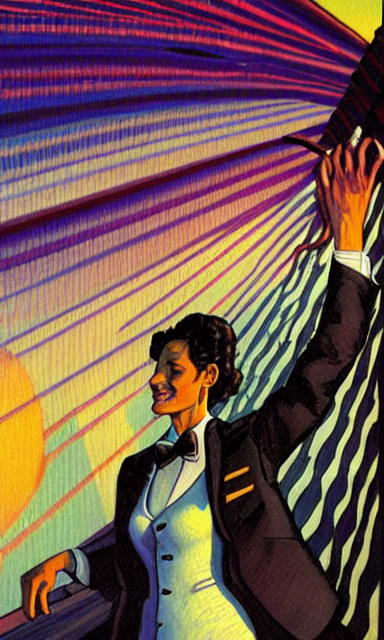

Global seed set to 9395229


Rendering animation frame 20 of 300
a beautiful woman in her 30s wearing a tuxedo, opera,  sunrise background, painting by Jean Giraud! 9395229
Angle: 0.0 Zoom: 1.03
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0


  0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:

import gc, torch
# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

import os
from types import SimpleNamespace
import time, random, json
#@markdown **Load Settings**
override_settings_with_file = True #@param {type:"boolean"}
custom_settings_file = "configs/current.txt"#@param {type:"string"}

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()
args = {}
args["prompts"] = {}

if override_settings_with_file:
    print(f"reading custom settings from {custom_settings_file}")
    if not os.path.isfile(custom_settings_file):
        print('The custom settings file does not exist. The in-notebook settings will be used instead')
    else:
        with open(custom_settings_file, "r") as f:
            jdata = json.loads(f.read())
            animation_prompts = jdata["prompts"]
            # args.prompts = animation_prompts
            for i, k in enumerate(args_dict):
                if k in jdata:
                    args_dict[k] = jdata[k]
                else:
                    print(f"key {k} doesn't exist in the custom settings data! using the default value of {args_dict[k]}")
            for i, k in enumerate(anim_args_dict):
                if k in jdata:
                    anim_args_dict[k] = jdata[k]
                else:
                    print(f"key {k} doesn't exist in the custom settings data! using the default value of {anim_args_dict[k]}")
            print(args_dict)
            print(anim_args_dict)

            
print("animaattttt", animation_prompts, args)
args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args, animation_prompts)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args, animation_prompts)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args, animation_prompts)
else:
    render_image_batch(args)    

In [ ]:
5

# Create video from frames

In [156]:

# !apt-get update
# !apt-get install sudo

# image_path = os.path.join(args.outdir, f"{args.timestring}_*.png")
# image_path

In [162]:
import cv2
import numpy as np
import glob


skip_video_for_run_all = False #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/beyonce/20220928090240_%05d.png" #@param {type:"string"}
mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220928090240.mp4" #@param {type:"string"}


FRAME_RATE = 18


if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode


    if use_manual_settings:
        max_frames = "500" #@param {type:"string"}
    else:
        # image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
        image_path = os.path.join(args.outdir, f"{args.timestring}_*.png")
        mp4_path = os.path.join(args.outdir, f"v_{args.timestring}.mp4")
        print(mp4_path, "pp")
        max_frames = str(anim_args.max_frames)
    
    print(f"{image_path} -> {mp4_path}")
    
    size=(0,0)
    img_array = []
    
    for filename in glob.glob(image_path):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    
    # print(img_array)
    # fourcc = cv2.VideoWriter_fourcc(*'H264')
    
    video = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc(*'MP4V'), FRAME_RATE, (width,height))

    for image in img_array:
        video.write(image)
        
    cv2.destroyAllWindows()
    video.release()
    # out = cv2.VideoWriter('hello.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
    # for i in range(len(img_array)):
    #     out.write(img_array[i])
    # out.release()
    # make video
#     cmd = [
#         'ffmpeg',
#         '-y',
#         '-vcodec', 'png',
#         '-r', str(fps),
#         '-start_number', str(0),
#         '-i', image_path,
#         '-frames:v', max_frames,
#         '-c:v', 'libx264',
#         '-vf',
#         f'fps={fps}',
#         '-pix_fmt', 'yuv420p',
#         # '-crf', '17',
#         # '-preset', 'veryfast',
#         #   '--enable-gpl',
#         # '--enable-libx264',
      
#         mp4_path
#     ]
#     process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = process.communicate()
#     if process.returncode != 0:
#         print(stderr)
#         raise RuntimeError(stderr)

#     mp4 = open(mp4_path,'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#     # display.display( display.HTML(f'<video controls loop><source src="{data_url}" download= type="video/mp4"></video>') )

../outputs/b/v_20221002122554.mp4 pp
../outputs/b/20221002122554_*.png -> ../outputs/b/v_20221002122554.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
